In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

## 0. 数据清洗

In [ ]:
bigfile = open('/Users/chengjun/百度云同步盘/Writing/OWS/ows-raw.txt', 'rb')
chunkSize = 10000000
chunk = bigfile.readlines(chunkSize)
block = ''
with open("/Users/chengjun/百度云同步盘/Writing/OWS/ows-clean.txt", 'w') as f:
    while chunk:
        blocks = []
        for line in chunk:
            block += line.replace('\n', '')
            block_length = len(block.split(','))
            if block_length >= 14:
                blocks.append(block)
                block = ''
        for i in blocks:
            f.write(i + '\n')
        chunk = bigfile.readlines(chunkSize)

## 1. 数据总量

In [120]:
from collections import defaultdict
import csv

data_dict = defaultdict(list)

error_num = 0
line_num = 0
total_num = 0

bigfile = open('/Users/chengjun/百度云同步盘/Writing/OWS/ows-clean.txt', 'rb')
chunkSize = 100000000
chunk = bigfile.readlines(chunkSize)
while chunk:
    total_num += len(chunk)
    lines = csv.reader((line.replace('\x00','') for line in chunk), delimiter=',', quotechar='"')
    for i in lines:
        line_num +=1
        try:
            date = i[3]
            if len(date) == 10:
                data_dict[date].append(i[8])
            else:
                error_num+=1
        except:
            pass
    chunk = bigfile.readlines(chunkSize)
print line_num, total_num, error_num

6602141 6602186 21


#### If you can see \x00 or \0, then you definitely have NULL bytes in the file, and you need to replace them before using csv.reader http://stackoverflow.com/questions/4166070/python-csv-error-line-contains-null-byte

##### 注释：Error: line contains NULL byte是造成40tweets无法解析的关键, 21个不是日期，共损失60条tweets。

In [121]:
" , ".join(data_dict.keys())

'2012-01-23 , 2011-10-25 , 2011-10-24 , 2011-12-10 , 2011-12-11 , 2011-12-12 , 2011-12-13 , 2011-12-14 , 2011-12-15 , 2011-12-16 , 2011-12-17 , 2011-12-18 , 2011-12-19 , 2012-02-16 , 2012-02-17 , 2012-02-14 , 2012-02-15 , 2012-02-12 , 2012-02-13 , 2012-02-10 , 2012-02-11 , 2012-02-18 , 2011-12-07 , 2011-12-06 , 2011-12-05 , 2011-12-04 , 2011-12-03 , 2011-12-02 , 2011-12-01 , 2011-11-20 , 2011-11-21 , 2011-11-22 , 2011-11-23 , 2011-11-24 , 2011-11-25 , 2011-12-09 , 2011-12-08 , 2012-02-05 , 2012-02-04 , 2012-02-07 , 2012-02-06 , 2012-02-01 , 2012-02-03 , 2012-02-02 , 2012-02-09 , 2012-02-08 , 2011-11-11 , 2011-10-31 , 2011-11-28 , 2012-01-28 , 2011-11-29 , 2012-01-26 , 2012-01-27 , 2012-01-24 , 2012-01-25 , 2012-01-22 , 2011-10-29 , 2012-01-20 , 2012-01-21 , 2011-10-28 , 2011-11-30 , 2011-10-23 , 2011-10-22 , 2011-10-21 , 2011-10-20 , 2011-10-27 , 2012-01-31 , 2012-01-30 , 2011-10-26 , 2011-11-26 , 2011-11-27 , 2012-01-01 , 2012-01-02 , 2012-01-03 , 2012-01-04 , 2012-01-05 , 2012-01-06 

## 2. 每天的tweets数量

In [123]:
import pandas as pd

data = [[i, len(data_dict[i]), len(set(data_dict[i]))] for i in data_dict]
dat = pd.DataFrame(data, columns = ['date', 'tweets', 'users'])
dat.date = pd.to_datetime(dat.date)
dat = dat.sort(['date'])

In [126]:
import numpy as np
np.sum(dat.tweets)

6602120

In [127]:
dat.describe()

,tweets,users
count,136.000000,136.000000
mean,48545.000000,16800.360294
std,51250.621113,14859.205183
min,4859.000000,2012.000000
25%,15803.750000,5945.500000
50%,37204.500000,13153.000000
75%,64630.250000,23297.250000
max,409075.000000,98934.000000


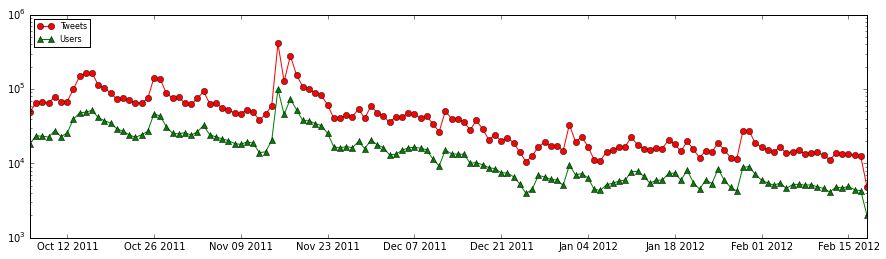

In [196]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 4),facecolor='white')

plt.plot(dat.date, dat.tweets, 'r-o', label = "Tweets")
plt.plot(dat.date, dat.users, 'g-^', label = "Users")
plt.legend(loc=2,fontsize=8)
plt.yscale('log')
plt.show()

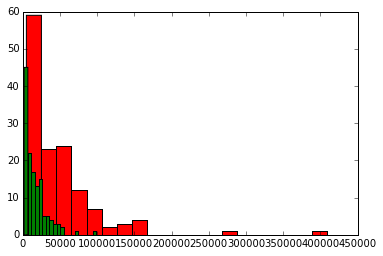

In [277]:
plt.hist(dat.tweets, 20, color= 'r')
plt.hist(dat.users, 20, color='g')
plt.show()

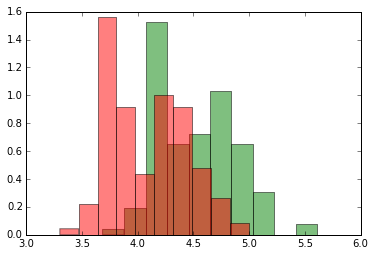

In [276]:
n, bins, patches = plt.hist(np.log10(dat.tweets),10,normed = True, facecolor='green', alpha=0.5)
n, bins, patches = plt.hist(np.log10(dat.users),10,normed = True, facecolor='red', alpha=0.5)

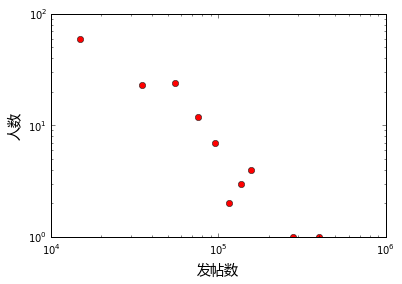

In [335]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r'/Users/chengjun/github/cjc2016/data/msyh.ttf', size=14) 

histo, bin_edges = np.histogram(dat.tweets, 20)
bin_center = 0.5*(bin_edges[1:] + bin_edges[:-1])

plt.loglog(bin_center,histo,'ro',linewidth=2)  
plt.xlabel(u'发帖数', fontproperties=font)
plt.ylabel(u'人数', fontproperties=font)
plt.show()


In [358]:
import statsmodels.api as sm
from collections import defaultdict
import numpy as np

def powerPlot(d_value, d_freq, color, marker):
    d_freq = [i + 1 for i in d_freq]
    d_prob = [float(i)/sum(d_freq) for i in d_freq]
    #d_rank = ss.rankdata(d_value).astype(int)
    x = np.log(d_value)
    y = np.log(d_prob)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant,beta = res.params
    r2 = res.rsquared
    plt.plot(d_value, d_prob, linestyle = '',  color = color, marker = marker)
    plt.plot(d_value, np.exp(constant+x*beta),"red")
    plt.xscale('log'); plt.yscale('log')
    plt.text(max(d_value)/4,max(d_prob)/2,
             r'$\beta$ = ' + str(round(beta,2)) +'\n' + r'$R^2$ = ' + str(round(r2, 2)))


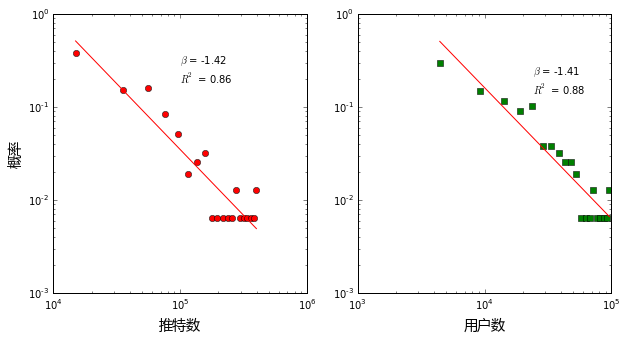

In [359]:
fig = plt.figure(figsize=(10, 5),facecolor='white')
ax = fig.add_subplot(1,2,1)
histo, bin_edges = np.histogram(dat.tweets, 20)
bin_center = 0.5*(bin_edges[1:] + bin_edges[:-1])
powerPlot(bin_center,histo, 'r', 'o')
#lg=plt.legend(labels = [u'Tweets', u'Fit'], loc=3, fontsize=20)
plt.ylabel(u'概率', fontproperties=font)
plt.xlabel(u'推特数', fontproperties=font)

ax = fig.add_subplot(1,2,2)
histo, bin_edges = np.histogram(dat.users, 20)
bin_center = 0.5*(bin_edges[1:] + bin_edges[:-1])
powerPlot(bin_center,histo, 'g', 's')
#lg=plt.legend(labels = [u'Users', u'Fit'], loc=3, fontsize=20)
plt.xlabel(u'用户数', fontproperties=font)

plt.show()

In [250]:
week = range(len(dat.date))
week = [i/7 for i in week]

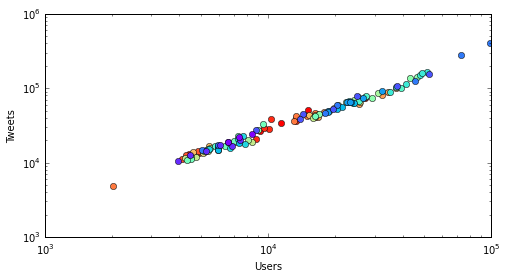

In [251]:
fig = plt.figure(figsize=(8, 4),facecolor='white')
cmap = cm.get_cmap('rainbow_r',np.max(week)+1)
for i, j in enumerate(week):
    plt.plot(dat.users[i], dat.tweets[i], color = cmap(j), marker = 'o')
plt.yscale('log');plt.xscale('log')
plt.xlabel('Users');plt.ylabel('Tweets')
plt.show()

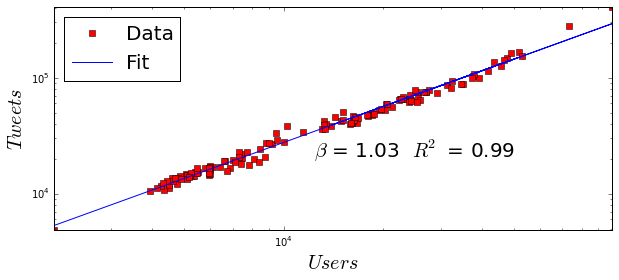

In [264]:
import statsmodels.api as sm
cmap = cm.get_cmap('rainbow_r',len(dat.date))

x = np.log(dat.users)
y = np.log(dat.tweets)
xx = sm.add_constant(x, prepend=True)
res = sm.OLS(y,xx).fit()
constant,beta = res.params
r2 = res.rsquared
fig = plt.figure(figsize=(10, 4),facecolor='white')
plt.plot(dat.users, dat.tweets, 'rs', label= 'Data')
plt.plot(np.exp(x), np.exp(constant + x*beta),"-", label = 'Fit')
plt.yscale('log');plt.xscale('log')
plt.xlabel(r'$Users$', fontsize = 20)
plt.ylabel(r'$Tweets$', fontsize = 20)
plt.text(max(dat.users)/8,max(dat.tweets)/20,
         r'$\beta$ = ' + str(round(beta,2)) +'\t' + r'$R^2$ = ' + str(round(r2, 2)), fontsize = 20)
plt.legend(loc=2,fontsize=20, numpoints=1)# frameon = False)
plt.axis('tight')
plt.show()
#plt.savefig('simple plot.pdf',dpi = 200)


## 3. 文本挖掘

### Extracting Tweet Entities

http://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/

Twitter has not always extracted tweet entities but you can easily derive them yourself
with the help of a third-party package called twitter_text, as shown in
Example 9-18. You can install twitter-text with pip using the command pip install
twitter-text-py.

In [6]:
import re
import twitter_text #pip install twitter-text-py

tweet = '''RT @AnonKitsu: ALERT!!!!!!!!!!COPS ARE KETTLING PROTESTERS IN PARK W HELICOPTERS AND PADDYWAGONS!!!! 
            #OCCUPYWALLSTREET #OWS #OCCUPYNY PLEASE @chengjun @mili http://computational-communication.com 
            http://ccc.nju.edu.cn RT !!HELP!!!!'''

def extract_rt_user(tweet):
    rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
    try:
        rt_user_name = rt_patterns.findall(tweet)[0][1].strip(' @')
        return rt_user_name
    except IndexError, e:
        pass
    
ex = twitter_text.Extractor(tweet)
at_names = ex.extract_mentioned_screen_names()
urls = ex.extract_urls()
hashtags = ex.extract_hashtags()
rt_user = extract_rt_user(tweet)
print at_names, urls, hashtags, rt_user

[u'AnonKitsu', u'chengjun', u'mili'] [u'http://computational-communication.com', u'http://ccc.nju.edu.cn'] [u'OCCUPYWALLSTREET', u'OWS', u'OCCUPYNY'] AnonKitsu


\ue415 \ue056 \ue057 \ue414 \ue405 \ue106 \ue418 \ue417 \ue40d \ue40a \ue404 \ue105 \ue409 \ue40e \ue402 \ue108 \ue403 \ue058 \ue407 \ue401 \ue40f \ue40b \ue406 \ue413 \ue411 \ue412 \ue410 \ue107 \ue059 \ue416 \ue408 \ue40c \ue11a \ue10c \ue32c \ue32a \ue32d \ue328 \ue32b \ue022 \ue023 \ue327 \ue329 \ue32e \ue335 \ue334 \ue337 \ue336 \ue13c \ue330 \ue331 \ue326 \ue03e \ue11d \ue05a \ue00e \ue421 \ue420 \ue00d \ue010 \ue011 \ue41e \ue012 \ue422 \ue22e \ue22f \ue231 \ue230 \ue427 \ue41d \ue00f \ue41f \ue14c \ue201 \ue115 \ue428 \ue51f \ue429 \ue424 \ue423 \ue253 \ue426 \ue111 \ue425 \ue31e \ue31f \ue31d \ue001 \ue002 \ue005 \ue004 \ue51a \ue519 \ue518 \ue515 \ue516 \ue517 \ue51b \ue152 \ue04e \ue51c \ue51e \ue11c \ue536 \ue003 \ue41c \ue41b \ue419 \ue41a  \ue04a \ue04b \ue049 \ue048 \ue04c \ue13d \ue443 \ue43e \ue04f \ue052 \ue053 \ue524 \ue52c \ue52a \ue531 \ue050 \ue527 \ue051 \ue10b \ue52b \ue52f \ue109 \ue528 \ue01a \ue134 \ue530 \ue529 \ue526 \ue52d \ue521 \ue523 \ue52e \ue055 \ue525 \ue10a \ue522 \ue019 \ue054 \ue520 \ue306 \ue030 \ue304 \ue110 \ue032 \ue305 \ue303 \ue118 \ue447 \ue119 \ue307 \ue308 \ue444 \ue441  \ue436 \ue437 \ue438 \ue43a \ue439 \ue43b \ue117 \ue440 \ue442 \ue446 \ue445 \ue11b \ue448 \ue033 \ue112 \ue325 \ue312 \ue310 \ue126 \ue127 \ue008 \ue03d \ue00c \ue12a \ue00a \ue00b \ue009 \ue316 \ue129 \ue141 \ue142 \ue317 \ue128 \ue14b \ue211 \ue114 \ue145 \ue144 \ue03f \ue313 \ue116 \ue10f \ue104 \ue103 \ue101 \ue102 \ue13f \ue140 \ue11f \ue12f \ue031 \ue30e \ue311 \ue113 \ue30f \ue13b \ue42b \ue42a \ue018 \ue016 \ue015 \ue014 \ue42c \ue42d \ue017 \ue013 \ue20e \ue20c \ue20f \ue20d \ue131 \ue12b \ue130 \ue12d \ue324 \ue301 \ue148 \ue502 \ue03c \ue30a \ue042 \ue040 \ue041 \ue12c \ue007 \ue31a \ue13e \ue31b \ue006 \ue302 \ue319 \ue321 \ue322 \ue314 \ue503 \ue10e \ue318 \ue43c \ue11e \ue323 \ue31c \ue034 \ue035 \ue045 \ue338 \ue047 \ue30c \ue044 \ue30b \ue043 \ue120 \ue33b \ue33f \ue341 \ue34c \ue344 \ue342 \ue33d \ue33e \ue340 \ue34d \ue339 \ue147 \ue343 \ue33c \ue33a \ue43f \ue34b \ue046 \ue345 \ue346 \ue348 \ue347 \ue34a \ue349  \ue036 \ue157 \ue038 \ue153 \ue155 \ue14d \ue156 \ue501 \ue158 \ue43d \ue037 \ue504 \ue44a \ue146 \ue50a \ue505 \ue506 \ue122 \ue508 \ue509 \ue03b \ue04d \ue449 \ue44b \ue51d \ue44c \ue124 \ue121 \ue433 \ue202 \ue135 \ue01c \ue01d \ue10d \ue136 \ue42e \ue01b \ue15a \ue159 \ue432 \ue430 \ue431 \ue42f \ue01e \ue039 \ue435 \ue01f \ue125 \ue03a \ue14e \ue252 \ue137 \ue209 \ue154 \ue133 \ue150 \ue320 \ue123 \ue132 \ue143 \ue50b \ue514 \ue513 \ue50c \ue50d \ue511 \ue50f \ue512 \ue510 \ue50e  \ue21c \ue21d \ue21e \ue21f \ue220 \ue221 \ue222 \ue223 \ue224 \ue225 \ue210 \ue232 \ue233 \ue235 \ue234 \ue236 \ue237 \ue238 \ue239 \ue23b \ue23a \ue23d \ue23c \ue24d \ue212 \ue24c \ue213 \ue214 \ue507 \ue203 \ue20b \ue22a \ue22b \ue226 \ue227 \ue22c \ue22d \ue215 \ue216 \ue217 \ue218 \ue228 \ue151 \ue138 \ue139 \ue13a \ue208 \ue14f \ue20a \ue434 \ue309 \ue315 \ue30d \ue207 \ue229 \ue206 \ue205 \ue204 \ue12e \ue250 \ue251 \ue14a \ue149 \ue23f \ue240 \ue241 \ue242 \ue243 \ue244 \ue245 \ue246 \ue247 \ue248 \ue249 \ue24a \ue24b \ue23e \ue532 \ue533 \ue534 \ue535 \ue21a \ue219 \ue21b \ue02f \ue024 \ue025 \ue026 \ue027 \ue028 \ue029 \ue02a \ue02b \ue02c \ue02d \ue02e \ue332 \ue333 \u00a9 \u00ae \u2122

In [82]:
def cleanTweet(tweet):
    '''replace symbols, return word list'''
    #print tweet
    tweet = tweet.decode('utf-8').strip() 
    rt_name = extract_rt_user(tweet)
    ex = twitter_text.Extractor(tweet)
    at_names = ex.extract_mentioned_screen_names()
    urls = ex.extract_urls()
    hashtags = ex.extract_hashtags()
    for ia in at_names:
        tweet = tweet.replace(ia, '')
    for j in urls:
        tweet = tweet.replace(j, '')
    tweet = tweet.replace('RT @', '').replace('@', '').replace('&quot;', '').replace('#', '')
    seps = ['(', ')', '!', ':', '.', '?', ',', '=', u'\xa0', '/', '\\', '\n', '-', '|', ';', u'&amp', '*', "'", '+']
    for s in seps:
        tweet = tweet.replace(s, ' ')
    tweet = tweet.split(' ')
    tweet = [t.lower() for t in tweet if t != '']
    return tweet

In [83]:
import csv
import twitter_text #pip install twitter-text-py
from collections import defaultdict
import csv

data_dict = defaultdict(list)
bigfile = open('/Users/chengjun/百度云同步盘/Writing/OWS/ows-raw.txt', 'rb')
chunkSize = 10000
chunk = bigfile.readlines(chunkSize)
lines = csv.reader((line.replace('\0','') for line in chunk[:10]), delimiter=',', quotechar='"')
for i in lines:
    tweet = i[1]
    if tweet != 'Text':
        tweet = cleanTweet(tweet)
        print tweet

[u'alert', u'cops', u'are', u'kettling', u'protesters', u'in', u'park', u'w', u'helicopters', u'and', u'paddywagons', u'occupywallstreet', u'ows', u'occupyny', u'please', u'rt', u'help']
[u'interesting', u'interview', u'never', u'aired', u'wonder', u'why', u'by', u'fox', u'with', u'ows', u'protester']
[u'right', u'those', u'guys', u'have', u'a', u'victory', u'condition', u'regime', u'change', u'ows', u'doesn', u't', u'seem', u'to', u'have', u'a', u'goal', u'i', u'can', u'figure', u'out']
[u'occupy', u'wall', u'street', u'als', u'linke', u'antwort', u'auf', u'die', u'tea', u'party', u'occupywallstreet', u'ows']
[u'ows', u'white', u'shirt', u'brown', u'shirt']
[u'the', u'nypd', u'are', u'out', u'of', u'control', u'is', u'this', u'a', u'free', u'country', u'or', u'a', u'middle', u'east', u'dictatorship', u'occupywallstreet', u'ows', u'p2']
[u'1912', u'prediction', u're', u'founding', u'of', u'fed', u'then', u'we', u'shall', u'have', u'only', u'corporate', u'currency', u'a', u'soulless', u

In [84]:
lines = csv.reader((line.replace('\x00','') for line in chunk), delimiter=',', quotechar='"')
for i in lines:
    print i[3], cleanTweet(i[1])

Day [u'text']
2011-10-06 [u'alert', u'cops', u'are', u'kettling', u'protesters', u'in', u'park', u'w', u'helicopters', u'and', u'paddywagons', u'occupywallstreet', u'ows', u'occupyny', u'please', u'rt', u'help']
2011-10-06 [u'interesting', u'interview', u'never', u'aired', u'wonder', u'why', u'by', u'fox', u'with', u'ows', u'protester']
2011-10-06 [u'right', u'those', u'guys', u'have', u'a', u'victory', u'condition', u'regime', u'change', u'ows', u'doesn', u't', u'seem', u'to', u'have', u'a', u'goal', u'i', u'can', u'figure', u'out']
2011-10-06 [u'occupy', u'wall', u'street', u'als', u'linke', u'antwort', u'auf', u'die', u'tea', u'party', u'occupywallstreet', u'ows']
2011-10-06 [u'ows', u'white', u'shirt', u'brown', u'shirt']
2011-10-06 [u'the', u'nypd', u'are', u'out', u'of', u'control', u'is', u'this', u'a', u'free', u'country', u'or', u'a', u'middle', u'east', u'dictatorship', u'occupywallstreet', u'ows', u'p2']
2011-10-06 [u'1912', u'prediction', u're', u'founding', u'of', u'fed', 

In [85]:
from collections import defaultdict
import csv

import sys
def flushPrint(s):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % s)
    sys.stdout.flush()

data_dict = defaultdict(lambda: defaultdict(int))
error_num = 0
line_num = 0
total_num = 0

bigfile = open('/Users/chengjun/百度云同步盘/Writing/OWS/ows-clean.txt', 'rb')
chunkSize = 100000000
chunk = bigfile.readlines(chunkSize)
total_num += len(chunk)
while chunk:
    lines = csv.reader((line.replace('\x00','') for line in chunk), delimiter=',', quotechar='"')
    for i in lines:
        line_num +=1
        if line_num % 10000 ==0:
            flushPrint(line_num)
        try:
            date = i[3]
            tweet = i[1]
            if len(date) == 10:
                tweet = cleanTweet(tweet)
                for tt in tweet:
                    data_dict[tt][date] += 1
            else:
                error_num+=1
        except:
            pass
    chunk = bigfile.readlines(chunkSize)
print line_num, total_num, error_num

66000006602141 262259 21


In [89]:
len(data_dict)

547508

In [93]:
type(data_dict)

collections.defaultdict

In [90]:
data_dict.keys()[0]

u'wooda'

In [91]:
data_dict[u'wooda']

defaultdict(int, {'2011-11-19': 4, '2011-11-20': 1})

In [95]:
import json
with open('/Users/chengjun/百度云同步盘/Writing/OWS/term_vectors.json', 'w') as f:
    json.dump(data_dict, f)

# 提取主要变量每天出现的次数

In [10]:
import re
import twitter_text #pip install twitter-text-py
import csv
import sys

def flushPrint(s):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % s)
    sys.stdout.flush()
    
def extract_rt_user(tweet):
    rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
    try:
        rt_user_name = rt_patterns.findall(tweet)[0][1].strip(' @')
        return rt_user_name
    except IndexError, e:
        pass

In [11]:
from collections import defaultdict
import csv

bigfile = open('/Users/chengjun/百度云同步盘/Writing/OWS/ows-clean.txt', 'rb')
chunkSize = 100000000
chunk = bigfile.readlines(chunkSize)

# format: data[date][attribute] = int
at_dict = defaultdict(lambda: defaultdict(int))
rt_dict = defaultdict(lambda: defaultdict(int))
url_dict = defaultdict(lambda: defaultdict(int))
tag_dict = defaultdict(lambda: defaultdict(int))
user_dict = defaultdict(lambda: defaultdict(int))

error_num =0
line_num = 0
while chunk:
    lines = csv.reader((line.replace('\x00','') for line in chunk), delimiter=',', quotechar='"')
    for i in lines:
        line_num +=1
        if line_num % 10000 ==0:
            flushPrint(line_num)
        try:
            date = i[3]
            user = i[8] # from_user_id
            tweet = i[1]
            ex = twitter_text.Extractor(tweet)
            at_names = ex.extract_mentioned_screen_names()
            urls = ex.extract_urls()
            hashtags = ex.extract_hashtags()
            rt_user = extract_rt_user(tweet)
            if len(date) == 10:
                if at_names:
                    for at_name in at_names:
                        at_dict[date][at_name]+=1
                if rt_user:
                    rt_dict[date][rt_user]+=1
                if urls:
                    for url in urls:
                        url_dict[date][url]+=1
                if hashtags:
                    for tag in hashtags:
                        tag_dict[date][tag]+=1
                user_dict[date][user]+=1
            else:
                error_num+=1
        except Exception, e:
            print e
            pass
    chunk = bigfile.readlines(chunkSize)
print line_num,  error_num

66000006602141 21


In [30]:
with open('/Users/chengjun/百度云同步盘/Writing/OWS/ows-clean.txt', 'rb') as f:
    lines = f.readlines(1)
    
lines = csv.reader((line.replace('\x00','') for line in lines), delimiter=',', quotechar='"')
for i in lines:
    print i[6]

Created At
2011-10-06 05:04:51
2011-10-06 05:04:51
2011-10-06 05:04:52
2011-10-06 05:04:52
2011-10-06 05:04:56
2011-10-06 05:04:57
2011-10-06 05:05:02
2011-10-06 05:05:03
2011-10-06 05:05:04
2011-10-06 05:05:04
2011-10-06 05:05:05
2011-10-06 05:05:06
2011-10-06 05:05:06
2011-10-06 05:05:12
2011-10-06 05:05:15
2011-10-06 05:05:15
2011-10-06 05:05:16
2011-10-06 05:05:16
2011-10-06 05:05:19
2011-10-06 05:05:20
2011-10-06 05:05:20
2011-10-06 05:05:23
2011-10-06 05:05:24


In [34]:
usertag_dict =  defaultdict(lambda: defaultdict(list))
usertag_dict[1][2].append(3)
usertag_dict[1][2].append(4)

usertag_dict

defaultdict(<function __main__.<lambda>>, {1: defaultdict(list, {2: [3, 4]})})

In [36]:
from collections import defaultdict
import csv

bigfile = open('/Users/chengjun/百度云同步盘/Writing/OWS/ows-clean.txt', 'rb')
chunkSize = 100000000
chunk = bigfile.readlines(chunkSize)

# format: data[date][attribute] = int
usertag_dict =  defaultdict(lambda: defaultdict(list))

error_num =0
line_num = 0
while chunk:
    lines = csv.reader((line.replace('\x00','') for line in chunk), delimiter=',', quotechar='"')
    for i in lines:
        line_num +=1
        if line_num % 10000 ==0:
            flushPrint(line_num)
        try:
            time = i[6]
            user = i[8] # from_user_id
            ex = twitter_text.Extractor(i[1])
            hashtags = ex.extract_hashtags()
            if len(time) == 19:
                if hashtags:
                    for tag in hashtags:
                        usertag_dict[user][time].append(tag)
            else:
                error_num+=1
        except Exception, e:
            print e
            pass
    chunk = bigfile.readlines(chunkSize)
print '-->', line_num, '-->', error_num

import json

with open('/Users/chengjun/百度云同步盘/Writing/GithubResearch/data/usertag_dict.json', 'w') as f:
    json.dump(usertag_dict, f)

6600000--> 6602141 --> 0


In [39]:
import json

# with open('/Users/chengjun/百度云同步盘/Writing/GithubResearch/data/at_dict.json', 'w') as f:
#     json.dump(at_dict, f)
# with open('/Users/chengjun/百度云同步盘/Writing/GithubResearch/data/rt_dict.json', 'w') as f:
#     json.dump(rt_dict, f)
# with open('/Users/chengjun/百度云同步盘/Writing/GithubResearch/data/url_dict.json', 'w') as f:
#     json.dump(url_dict, f)
# with open('/Users/chengjun/百度云同步盘/Writing/GithubResearch/data/tag_dict.json', 'w') as f:
#     json.dump(tag_dict, f)
# with open('/Users/chengjun/百度云同步盘/Writing/GithubResearch/data/user_dict.json', 'w') as f:
#     json.dump(user_dict, f)

at_dict = json.load(open('/Users/chengjun/百度云同步盘/Writing/GithubResearch/data/at_dict.json') )
rt_dict = json.load(open('/Users/chengjun/百度云同步盘/Writing/GithubResearch/data/rt_dict.json') )
url_dict = json.load(open('/Users/chengjun/百度云同步盘/Writing/GithubResearch/data/url_dict.json') )
tag_dict = json.load(open('/Users/chengjun/百度云同步盘/Writing/GithubResearch/data/tag_dict.json') )
user_dict = json.load(open('/Users/chengjun/百度云同步盘/Writing/GithubResearch/data/user_dict.json') )


In [40]:
len(user_dict),len(at_dict),len(rt_dict),len(url_dict),len(tag_dict)

(136, 136, 136, 136, 136)

In [41]:
import numpy as np

data_dict = {}
for u in user_dict:
    userNum = len(user_dict[u].keys())
    tweetNum = np.sum(user_dict[u].values())
    atUniq = len(at_dict[u].keys())
    atNum = np.sum(at_dict[u].values())
    rtUniq = len(rt_dict[u].keys())
    rtNum = np.sum(rt_dict[u].values())
    urlUniq = len(url_dict[u].keys())
    urlNum = np.sum(url_dict[u].values())
    tagUniq = len(tag_dict[u].keys())
    tagNum = np.sum(tag_dict[u].values())
    data_dict[u] = (u, userNum, tweetNum, atUniq, atNum, rtUniq, rtNum, urlUniq, urlNum, tagUniq, tagNum)

In [42]:
import pandas as pd

dat = pd.DataFrame(data_dict.values(), 
                   columns = ['date',  'users', 'tweets','mentionUnique', 'mentions', 
                             'retweetUnique', 'retweets', 'urlUnique', 'urls', 'hashtagUnique', 'hashtags'])
dat.date = pd.to_datetime(dat.date)
dat = dat.sort(['date'])

/Users/chengjun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [43]:
dat[:2]

,date,users,tweets,mentionUnique,mentions,retweetUnique,retweets,urlUnique,urls,hashtagUnique,hashtags
108,2011-10-06,18487,49638,7810,54874,4969,30841,9783,22807,4921,112364
107,2011-10-07,23460,65238,9972,72744,6493,39318,14479,33632,6748,149517


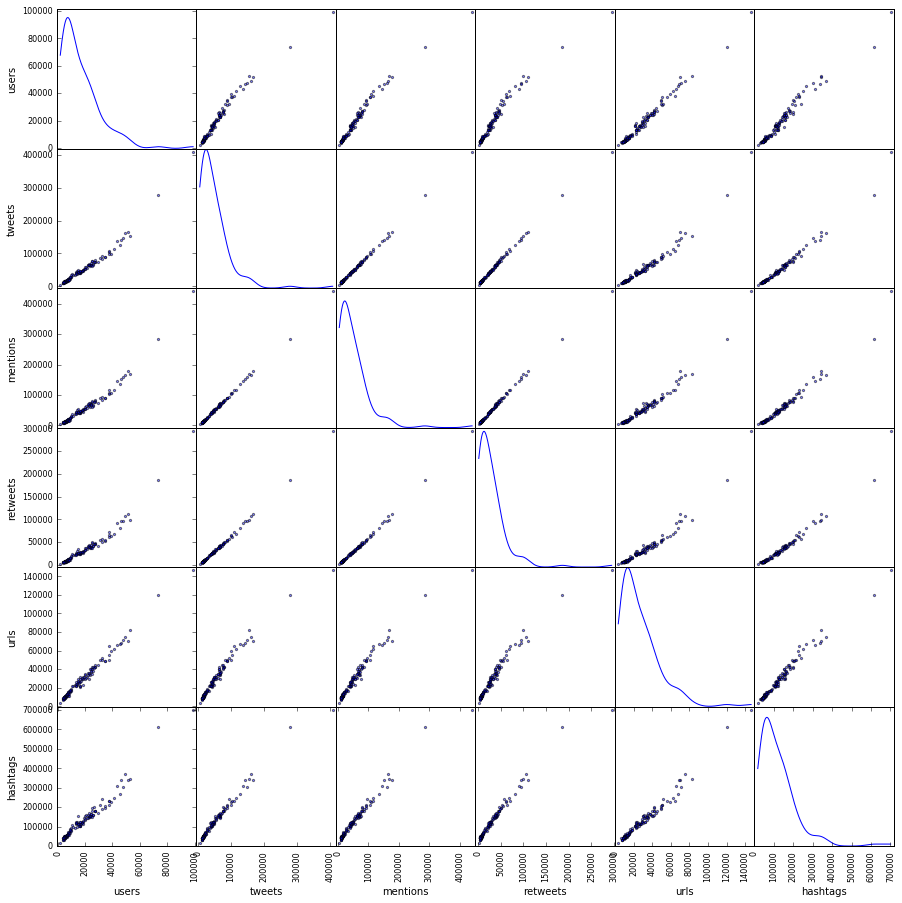

In [72]:
from pandas.tools import plotting

plotting.scatter_matrix(dat[['users', 'tweets', 'mentions','retweets', 'urls', 'hashtags']], 
                       figsize=(15, 15), diagonal='kde') 
plt.show()

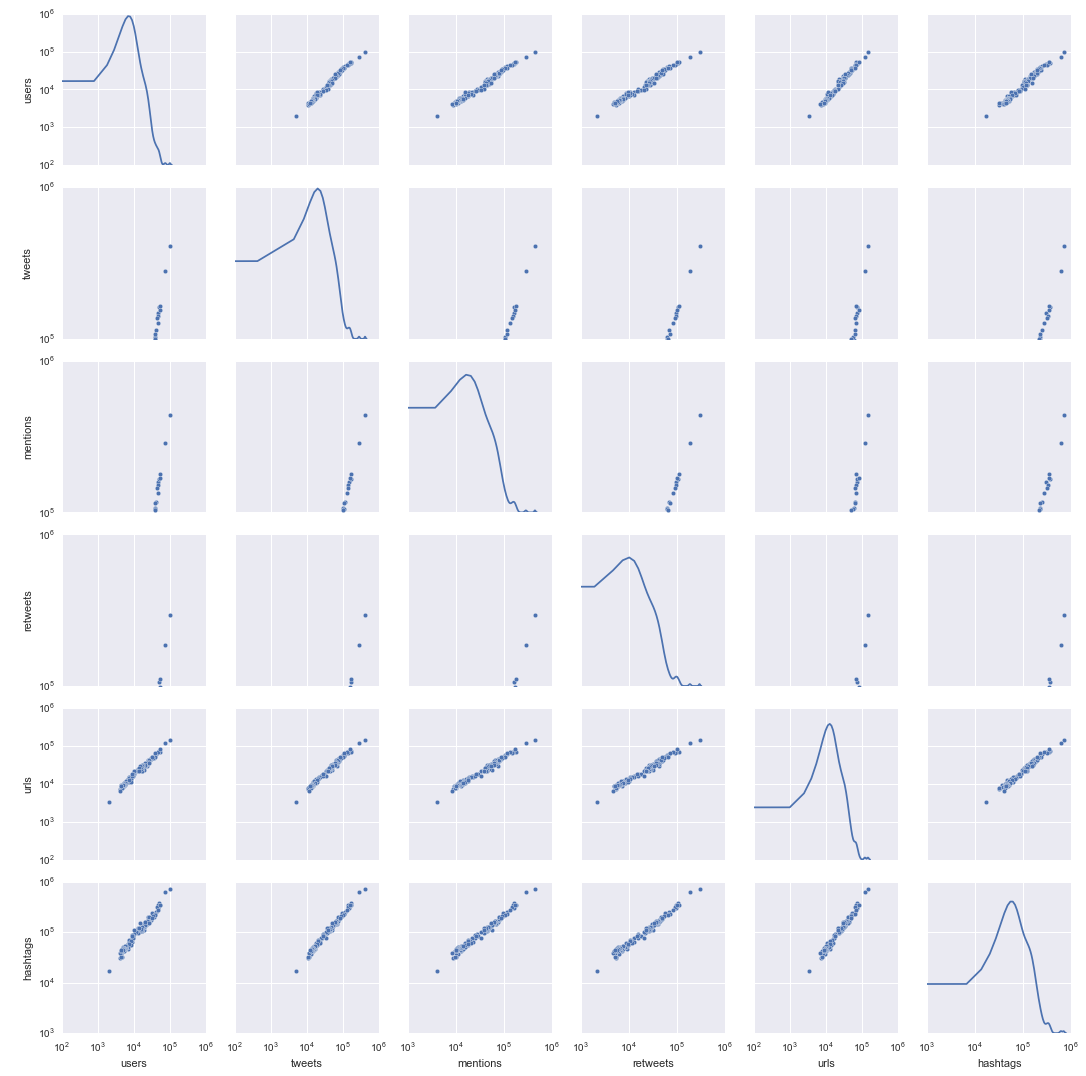

In [91]:
import seaborn

grid = seaborn.pairplot(dat, vars=['users', 'tweets', 'mentions','retweets', 'urls', 'hashtags'],
                   diag_kind="kde") 
grid.set(xscale="log", yscale="log")

plt.show()

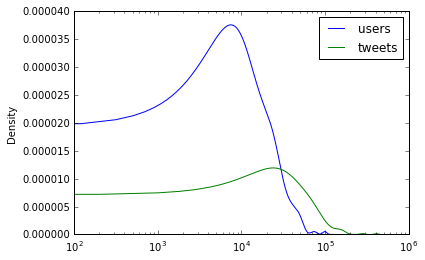

In [82]:
dat.users.plot(kind='kde')
dat.tweets.plot(kind='kde')
plt.legend(loc=1,fontsize=12)
plt.xscale('log')#;plt.yscale('log')
plt.show()

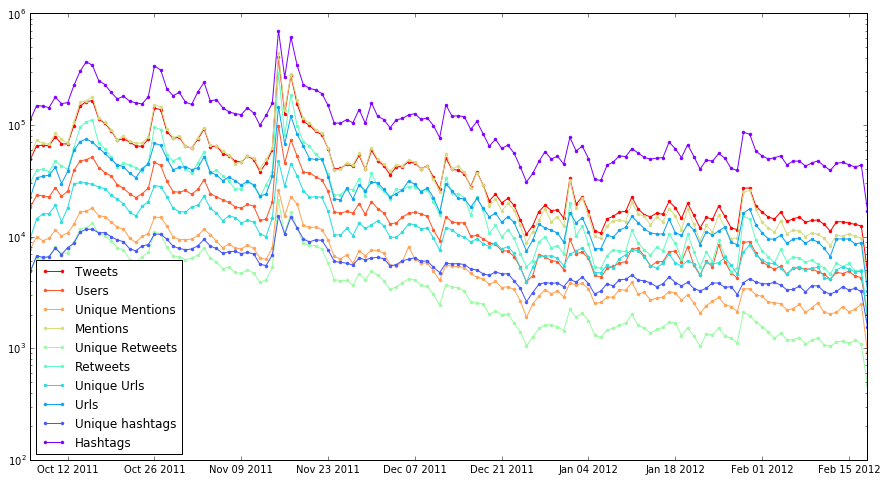

In [62]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 8),facecolor='white')
cmap = cm.get_cmap('rainbow_r',10)

plt.plot(dat.date, dat.tweets, linestyle='-',marker='.',color=cmap(0), label = "Tweets")
plt.plot(dat.date, dat.users, linestyle='-',marker='.',color=cmap(1), label = "Users")
plt.plot(dat.date, dat.mentionUnique, linestyle='-',marker='.',color=cmap(2), label = "Unique Mentions")
plt.plot(dat.date, dat.mentions, linestyle='-',marker='.',color=cmap(3), label = "Mentions")
plt.plot(dat.date, dat.retweetUnique, linestyle='-',marker='.',color=cmap(4), label = "Unique Retweets")
plt.plot(dat.date, dat.retweets, linestyle='-',marker='.',color=cmap(5), label = "Retweets")
plt.plot(dat.date, dat.urlUnique, linestyle='-',marker='.',color=cmap(6), label = "Unique Urls")
plt.plot(dat.date, dat.urls, linestyle='-',marker='.',color=cmap(7), label = "Urls")
plt.plot(dat.date, dat.hashtagUnique, linestyle='-',marker='.',color=cmap(8), label = "Unique hashtags")
plt.plot(dat.date, dat.hashtags,linestyle='-',marker='.',color=cmap(9), label = "Hashtags")

plt.legend(loc=3,fontsize=12)
plt.yscale('log')
plt.show()

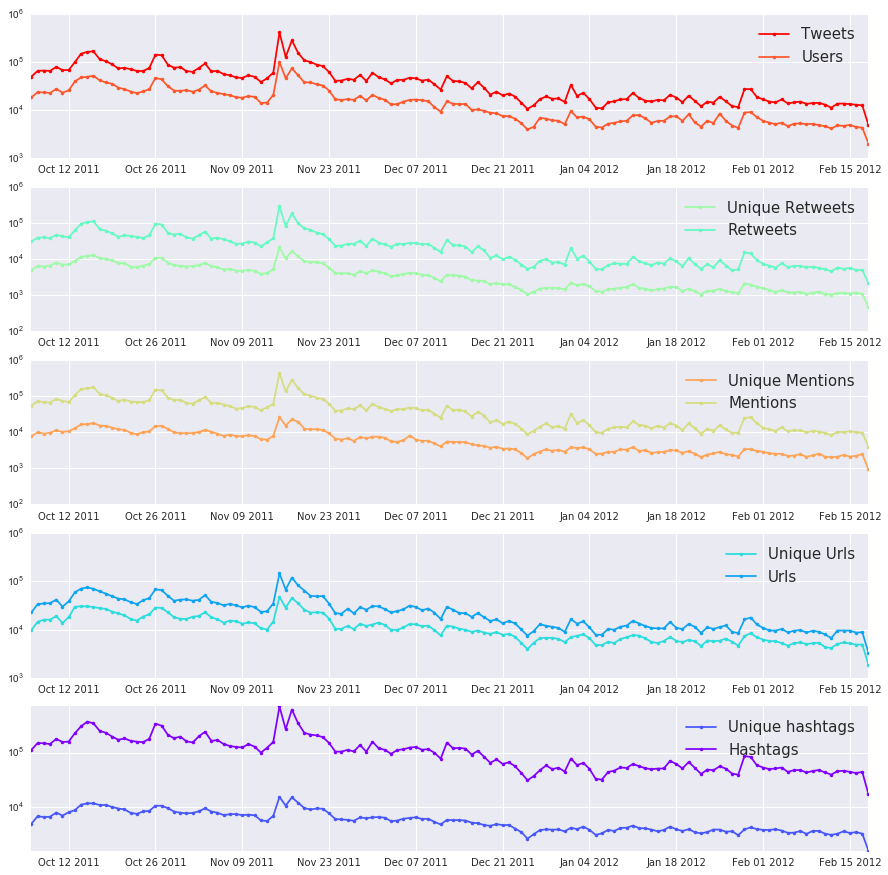

In [157]:
fig = plt.figure(figsize=(15,15),facecolor='white')
cmap = cm.get_cmap('rainbow_r',10)

ax = plt.subplot(511)
plt.plot(dat.date, dat.tweets, linestyle='-',marker='.',color=cmap(0), label = "Tweets")
plt.plot(dat.date, dat.users, linestyle='-',marker='.',color=cmap(1), label = "Users")
plt.legend(loc=1,fontsize=15)
plt.yscale('log')

ax = plt.subplot(512)
plt.plot(dat.date, dat.retweetUnique, linestyle='-',marker='.',color=cmap(4), label = "Unique Retweets")
plt.plot(dat.date, dat.retweets, linestyle='-',marker='.',color=cmap(5), label = "Retweets")
plt.legend(loc=1,fontsize=15)
plt.yscale('log')

ax = plt.subplot(513)
plt.plot(dat.date, dat.mentionUnique, linestyle='-',marker='.',color=cmap(2), label = "Unique Mentions")
plt.plot(dat.date, dat.mentions, linestyle='-',marker='.',color=cmap(3), label = "Mentions")
plt.legend(loc=1,fontsize=15)
plt.yscale('log')

ax = plt.subplot(514)
plt.plot(dat.date, dat.urlUnique, linestyle='-',marker='.',color=cmap(6), label = "Unique Urls")
plt.plot(dat.date, dat.urls, linestyle='-',marker='.',color=cmap(7), label = "Urls")
plt.legend(loc=1,fontsize=15)
plt.yscale('log')

ax = plt.subplot(515)
plt.plot(dat.date, dat.hashtagUnique, linestyle='-',marker='.',color=cmap(8), label = "Unique hashtags")
plt.plot(dat.date, dat.hashtags,linestyle='-',marker='.',color=cmap(9), label = "Hashtags")
plt.legend(loc=1,fontsize=15)
plt.yscale('log')

plt.axis('tight')
plt.show()

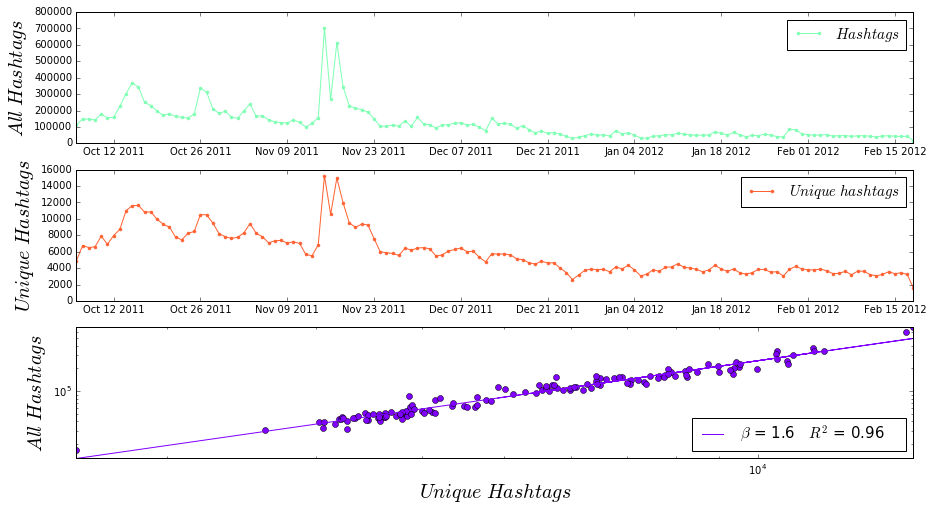

In [67]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt

cmap = cm.get_cmap('rainbow_r',9)

fig = plt.figure(figsize=(15, 8),facecolor='white')

ax = plt.subplot(311)
plt.plot(dat.date, dat.hashtags,linestyle='-',marker='.',color=cmap(4), label = "$Hashtags$")
plt.legend(loc=1,fontsize=15)
plt.ylabel(r'$All\;Hashtags$', fontsize = 20)

ax = plt.subplot(312)
plt.plot(dat.date, dat.hashtagUnique, linestyle='-',marker='.',color=cmap(1), label = "$Unique\; hashtags$")
plt.legend(loc=1,fontsize=15)
plt.ylabel(r'$Unique\;Hashtags$', fontsize = 20)

ax = plt.subplot(313)
linearFit(dat.hashtagUnique, dat.hashtags, '', cmap(8))
#plt.plot(dat.hashtagUnique, dat.hashtags,linestyle='',marker='.',color=cmap(9), label = "")
plt.legend(loc=4,fontsize=15)
plt.xlabel(r'$Unique\;Hashtags$', fontsize = 20)
plt.ylabel(r'$All\;Hashtags$', fontsize = 20)
#plt.yscale('log')
#plt.xscale('log')

plt.axis('tight')
plt.show()

In [58]:
import statsmodels.api as sm
cmap = cm.get_cmap('rainbow_r',len(dat.date))

def linearFit(xi, yi, var_name, color):
    x = np.log(xi)
    y = np.log(yi)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant,beta = res.params
    r2 = res.rsquared
    label_txt = r'$\beta$ = ' + str(round(beta,2)) +'\t' + r'$R^2$ = ' + str(round(r2, 2))  +'\t' + var_name
    plt.plot(xi, yi, linestyle='', color =color, marker = 'o', label = '')
    plt.plot(xi, np.exp(constant + x*beta),linestyle= "-", color =color,label = label_txt)
    plt.yscale('log');plt.xscale('log')
    plt.xlabel(r'$Users$', fontsize = 20)

#plt.savefig('simple plot.pdf',dpi = 200)

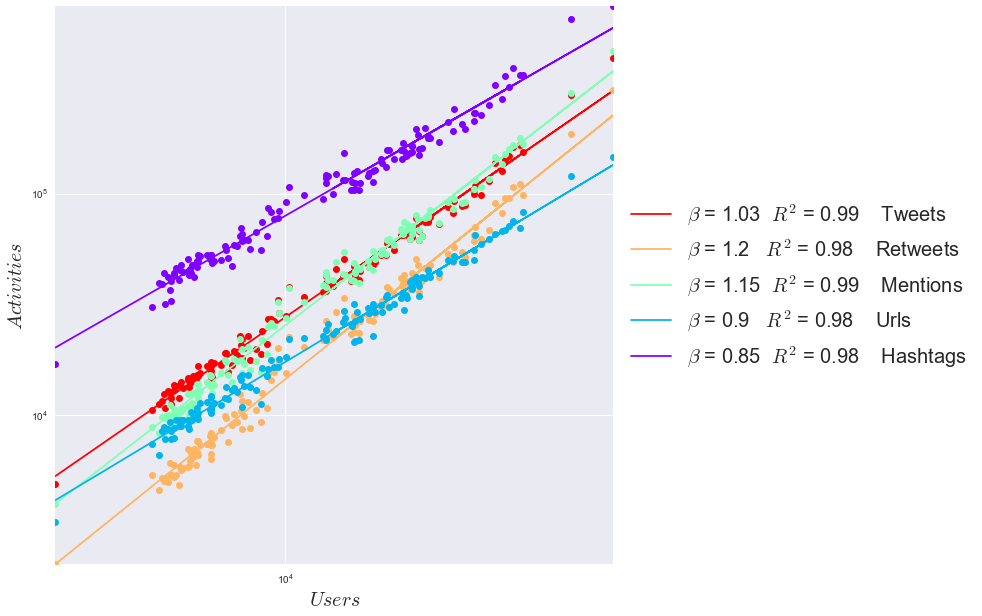

In [159]:
fig = plt.figure(figsize=(10, 10),facecolor='white')
cmap = cm.get_cmap('rainbow_r',5)

linearFit(dat.users, dat.tweets, 'Tweets', cmap(0))
linearFit(dat.users, dat.retweets, 'Retweets', cmap(1))
linearFit(dat.users, dat.mentions, 'Mentions', cmap(2))
linearFit(dat.users, dat.urls, 'Urls', cmap(3))
linearFit(dat.users, dat.hashtags, 'Hashtags', cmap(4))
plt.ylabel(r'$Activities$', fontsize = 20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20, numpoints=1, frameon = False )
plt.axis('tight')
plt.show()

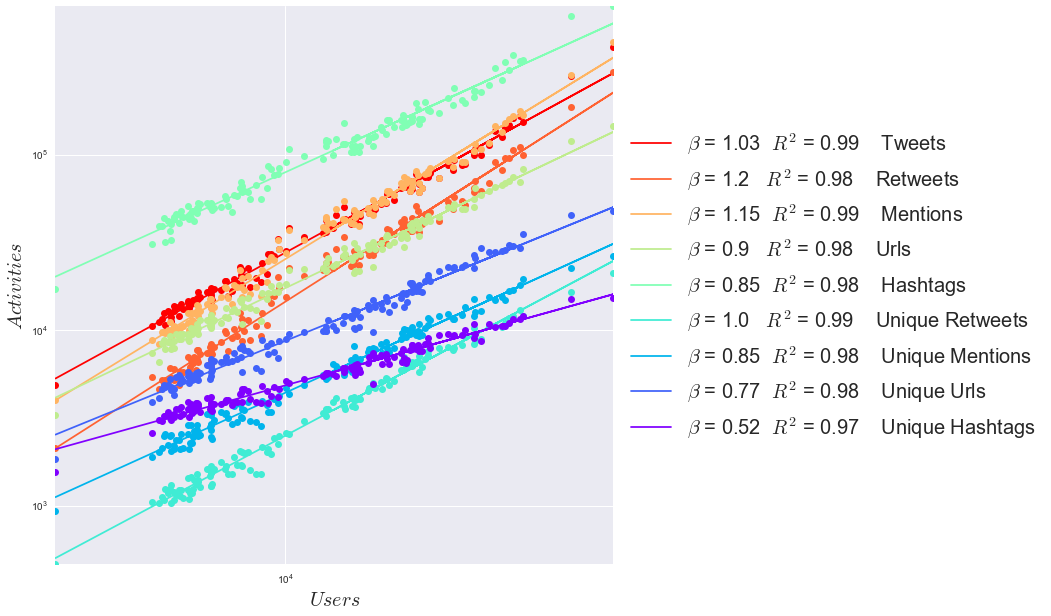

In [148]:
fig = plt.figure(figsize=(10, 10),facecolor='white')
cmap = cm.get_cmap('rainbow_r',9)

linearFit(dat.users, dat.tweets, 'Tweets', cmap(0))
linearFit(dat.users, dat.retweets, 'Retweets', cmap(1))
linearFit(dat.users, dat.mentions, 'Mentions', cmap(2))
linearFit(dat.users, dat.urls, 'Urls', cmap(3))
linearFit(dat.users, dat.hashtags, 'Hashtags', cmap(4))
linearFit(dat.users, dat.retweetUnique, 'Unique Retweets', cmap(5))
linearFit(dat.users, dat.mentionUnique, 'Unique Mentions', cmap(6))
linearFit(dat.users, dat.urlUnique, 'Unique Urls', cmap(7))
linearFit(dat.users, dat.hashtagUnique, 'Unique Hashtags', cmap(8))
plt.ylabel(r'$Activities$', fontsize = 20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20, numpoints=1, frameon = False )
plt.axis('tight')
plt.show()

In [151]:
def linearFit(xi, yi):
    x = np.log(xi)
    y = np.log(yi)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant,beta = res.params
    r2 = res.rsquared
    plt.plot(xi, yi, linestyle='',color = 'r', marker = 'o', label = '')
    plt.plot(xi, np.exp(constant + x*beta),linestyle= "-", label = '')
    plt.yscale('log');plt.xscale('log')
    plt.xlabel(r'$Users$', fontsize = 20)
    plt.text(max(dat.users)/8,max(dat.tweets)/20,
           r'$\beta$ = ' + str(round(beta,2)) +'\t' + r'$R^2$ = ' + str(round(r2, 2)), fontsize = 20)

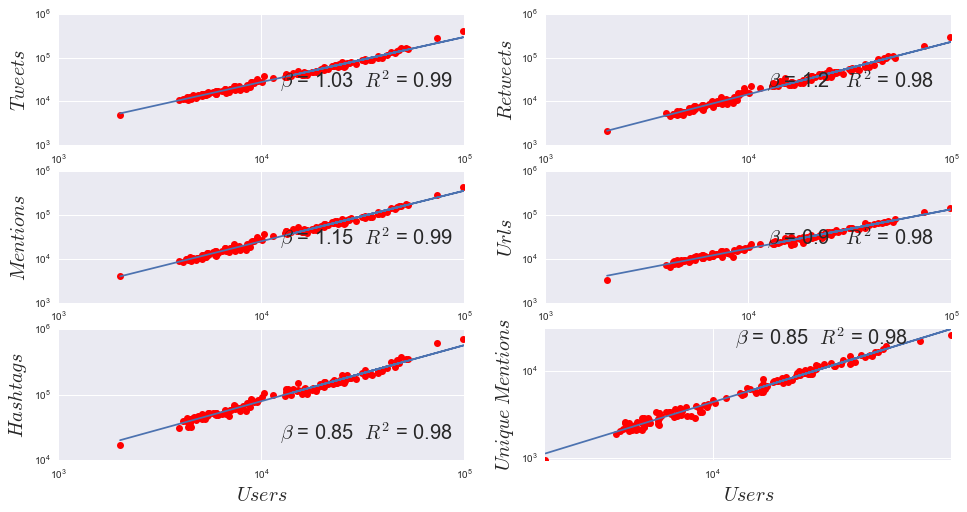

In [152]:
fig = plt.figure(figsize=(16, 8),facecolor='white')
ax = plt.subplot(321)
linearFit(dat.users, dat.tweets)
plt.ylabel(r'$Tweets$', fontsize = 20)
ax = plt.subplot(322)
linearFit(dat.users, dat.retweets)
plt.ylabel(r'$Retweets$', fontsize = 20)
ax = plt.subplot(323)
linearFit(dat.users, dat.mentions)
plt.ylabel(r'$Mentions$', fontsize = 20)
ax = plt.subplot(324)
linearFit(dat.users, dat.urls)
plt.ylabel(r'$Urls$', fontsize = 20)
ax = plt.subplot(325)
linearFit(dat.users, dat.hashtags)
plt.ylabel(r'$Hashtags$', fontsize = 20)
ax = plt.subplot(326)
linearFit(dat.users, dat.mentionUnique)
plt.ylabel(r'$Unique\: Mentions$', fontsize = 20)
plt.axis('tight')
plt.show()

## 4. 网络结构

In [68]:
len(chunk[41].split(','))

2